In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

In [2]:
from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo

In [64]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/greedy")

In [65]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/random")

In [66]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/landscape_maximizes")

In [67]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/mimic")

In [35]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.animation as animation
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM

In [68]:
newdata1 = dict(h5py.File("../data/random/random.hdf5"))
newdata2 = dict(h5py.File("../data/greedy/greedy.hdf5"))
newdata3 = dict(h5py.File("../data/mimic/mimic.hdf5"))
newdata4 = dict(h5py.File("../data/landscape_maximizes/landscape_maximizes.hdf5"))

In [9]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [10]:
def means_stds_of_pops_of_one_sim_index(pops_trial_index):
    mean_stds_list = []
    for step_index in range(steps):
        stds = np.std(pops_trial_index [step_index])
        means = np.mean(pops_trial_index[step_index])
        mean_stds_list.append([means, stds])
    return mean_stds_list

def means_stds_mode_of_pops_of_one_sim_index(pops_trial_index):
    mean_stds_mode_list = []
    for step_index in range(steps):
        total = sum(pops_trial_index[step_index])
        stds = np.std(pops_trial_index[step_index])
        means = np.mean(pops_trial_index[step_index])
        mode = max(pops_trial_index[step_index])
        mean_stds_mode_list.append([total,stds,means,mode])
    return mean_stds_mode_list

def extract_total(list_of_lists):
    return [sublist[0] for sublist in list_of_lists]
def extract_stds(list_of_lists):
    return [sublist[1] for sublist in list_of_lists]
def extract_means(list_of_lists):
    return [sublist[2] for sublist in list_of_lists]
def extract_mode(list_of_lists):
    return [sublist[3] for sublist in list_of_lists]

In [11]:
def moving_average(data, window_size=10):
    """
    Function to calculate the moving average of a given data array.
    
    Parameters:
    - data: The input data array.
    - window_size: The size of the moving average window.
    
    Returns:
    - moving_avg: The moving average array.
    """
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    return moving_avg

def plot_four_stats_as_function_of_time(list1, list2, list3,list4, filename='plot.png',title='plotname'):
    # Assuming both lists have the same length (representing time steps)
    time_steps = range(1, len(list1) + 1)
    
    # Calculate moving averages for both lists
    moving_avg_list1 = moving_average(list1)
    moving_avg_list2 = moving_average(list2)
    moving_avg_list3 = moving_average(list3)
    moving_avg_list4 = moving_average(list4)
    
    # Set the figure size (adjust as needed)
    plt.figure(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches
    
    # Plotting the lists and their moving averages
    plt.plot(time_steps, list1, color='blue', label='Random')
    plt.plot(time_steps, list2,color='orange', label='Greedy')
    plt.plot(time_steps, list3, color='red',label='Mimic')
    plt.plot(time_steps, list4, color='green',label='Landmax')
    plt.plot(time_steps[len(list1) - len(moving_avg_list1):], moving_avg_list1, linestyle='--', color='blue', label='Moving Average (Random)')
    plt.plot(time_steps[len(list2) - len(moving_avg_list2):], moving_avg_list2, linestyle='--', color='orange', label='Moving Average (Greedy)')
    plt.plot(time_steps[len(list3) - len(moving_avg_list3):], moving_avg_list3, linestyle='--', color='red', label='Moving Average (Mimic)')
    plt.plot(time_steps[len(list4) - len(moving_avg_list4):], moving_avg_list4, linestyle='--', color='green', label='Moving Average (Landmax)')    
    
    # Adding labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    
    # Adding legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    
    # Display the plot
    plt.grid(True)
    
    # Save the plot with the desired filename
    #plt.savefig(filename)
    
    # Show the plot (optional)
    plt.show()

def plot_four_stats_as_function_of_time_avg(list1, list2, list3,list4, filename='plot.png',title='plotname'):
    # Assuming both lists have the same length (representing time steps)
    time_steps = range(1, len(list1) + 1)
    
    # Calculate moving averages for both lists
    moving_avg_list1 = moving_average(list1)
    moving_avg_list2 = moving_average(list2)
    moving_avg_list3 = moving_average(list3)
    moving_avg_list4 = moving_average(list4)
    
    # Set the figure size (adjust as needed)
    plt.figure(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches
    
    # Plotting the lists and their moving averages
    #plt.plot(time_steps, list1, color='blue', label='Random')
#    plt.plot(time_steps, list2,color='orange', label='Greedy')
    #plt.plot(time_steps, list3, color='green',label='Land_max')
    #plt.plot(time_steps, list4, color='red',label='Mimic')
    plt.plot(time_steps[len(list1) - len(moving_avg_list1):], moving_avg_list1, linestyle='--', color='blue', label='Moving Average (Random)')
    plt.plot(time_steps[len(list2) - len(moving_avg_list2):], moving_avg_list2, linestyle='--', color='orange', label='Moving Average (Greedy)')
    plt.plot(time_steps[len(list3) - len(moving_avg_list3):], moving_avg_list3, linestyle='--', color='red', label='Moving Average (Mimic)')
    plt.plot(time_steps[len(list4) - len(moving_avg_list4):], moving_avg_list4, linestyle='--', color='green', label='Moving Average (Landmax)')    
    
    # Adding labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    
    # Adding legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    
    # Display the plot
    plt.grid(True)
    
    # Save the plot with the desired filename
   # plt.savefig(filename)
    
    # Show the plot (optional)
    plt.show()

In [12]:
#Concurrence of every pair
def concurrence_dicts(twoQdms, trial_index):
    concurrence_list = []
    for time_step in twoQdms[trial_index]:
        concurrence_dict = {}
        concurrence = measure.concurrence_of_every_pair_dict(time_step)
        # Filter out values below the precision threshold
        filtered_concurrence = {k: v if v >= 1e-6 else 0 for k, v in concurrence.items()}
        # Update the concurrence_dict with the filtered concurrence for the current time step
        concurrence_dict.update(filtered_concurrence)
        # Append the concurrence_dict to the list
        concurrence_list.append(concurrence_dict)
    return concurrence_list

In [14]:
# Call the two_point_dict function for each trial index
# Get the list of dictionaries containing two point values for each time step
def create_adjacency_matrix_two_dim(two_point_dict, num_nodes):
    adjacency_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for (node1, node2), two_point_value in two_point_dict.items():
        adjacency_matrix[node1][node2] = two_point_value
        adjacency_matrix[node2][node1] = two_point_value  # Assuming undirected graph
    return adjacency_matrix

In [15]:
def adjacency_matrices_list_two_dim(twoQdms, trial_index, num_nodes, two_point_dicts):
    # Get the list of dictionaries containing mutual information values for each time step
    two_point_dicts_list = two_point_dicts(twoQdms, trial_index)
    # Create adjacency matrices for each time step
    adjacency_matrices = []
    for two_point_dict in two_point_dicts_list:
        adj_matrix = create_adjacency_matrix_two_dim(two_point_dict, num_nodes)
        adjacency_matrices.append(adj_matrix)
    return adjacency_matrices

In [16]:
#Clustering Coefficient
def clustering_coeff_function_of_time(adjacency_matrix_list):
    C_list = []
    #adjacency_matrix_list=np.array(adjacency_matrix_list)
    for adj_mat in adjacency_matrix_list:
        adj_mat=np.array(adj_mat)
        M_sq = adj_mat@adj_mat
        sum_of_M_sq = np.sum(M_sq)
        M_cube = adj_mat@adj_mat@adj_mat
        M_cube_trace = np.trace(M_cube)
        C_list.append(M_cube_trace/sum_of_M_sq)
    return(C_list)

#Disparity
def disparity_function_of_time(adjacency_matrix_list, N):
    D_list = []
    for adj_mat in adjacency_matrix_list:
        M_row_sum_squared = np.sum(adj_mat, axis=1)**2
        M_row_sum_of_squared_elements = np.sum(adj_mat**2, axis=1)
        # Check for zero division before performing division
        Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)
        D_list.append(np.sum(Di) / N)
    return D_list

In [70]:
Concurrence_adj_random=adjacency_matrices_list_two_dim(twoQdmsrandom,0,8, concurrence_dicts)
Concurrence_adj_greedy=adjacency_matrices_list_two_dim(twoQdmsgreedy,0,8, concurrence_dicts)
Concurrence_adj_mimic=adjacency_matrices_list_two_dim(twoQdmsmimic,0,8, concurrence_dicts)
Concurrence_adj_landscape_max=adjacency_matrices_list_two_dim(twoQdmslandscape_max,0,8, concurrence_dicts)

In [69]:
twoQdmsrandom = get_2_qbit_dms(newdata1,8,"cN_2local","random")
twoQdmsgreedy = get_2_qbit_dms(newdata2,8,"cN_2local","greedy")
twoQdmsmimic = get_2_qbit_dms(newdata3,8,"cN_2local","mimic")
twoQdmslandscape_max = get_2_qbit_dms(newdata4,8,"cN_2local","landscape_maximizes")

In [18]:
def mean_std_per_qubit(concurrence_adj,num_qbits):
    mean_std_list=[]
    for adj_mat in concurrence_adj:
        mean_std_per_q_at_t=[]
        for q_index in range(num_qbits):
            mean_conc = np.mean(adj_mat[q_index])
            std_conc = np.std(adj_mat[q_index])
            max_conc = np.max(adj_mat[q_index])
            min_conc=np.min(adj_mat[q_index])
            mean_std_per_q_at_t.append([mean_conc,std_conc,max_conc,min_conc])
        mean_std_list.append(mean_std_per_q_at_t)
    return mean_std_list

In [71]:
mean_stds_conc_random= mean_std_per_qubit(Concurrence_adj_random,8)
mean_stds_conc_greedy= mean_std_per_qubit(Concurrence_adj_greedy,8)
mean_stds_conc_mimic= mean_std_per_qubit(Concurrence_adj_mimic,8)
mean_stds_conc_landscape_max= mean_std_per_qubit(Concurrence_adj_landscape_max,8)

In [29]:
def mean_conc_per_Q(mean_stds_conc):
    mean_conc_list = []
    for mean_std in mean_stds_conc:
        mean_at_that_time_step = []
        for mean_of_q in mean_std:
            mean_at_that_time_step.append(mean_of_q[0])
        mean_conc_list.append(mean_at_that_time_step)
    return mean_conc_list

In [72]:
mean_conc_random=mean_conc_per_Q(mean_stds_conc_random)
mean_conc_greedy=mean_conc_per_Q(mean_stds_conc_greedy)
mean_conc_mimic=mean_conc_per_Q(mean_stds_conc_mimic)
mean_conc_landmax=mean_conc_per_Q(mean_stds_conc_landscape_max)

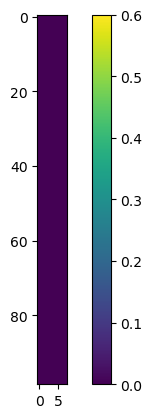

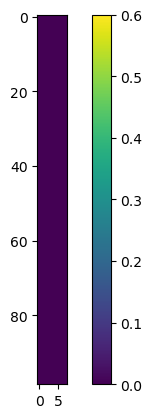

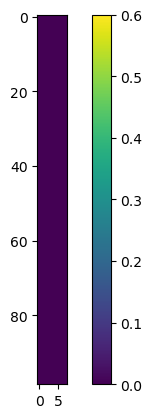

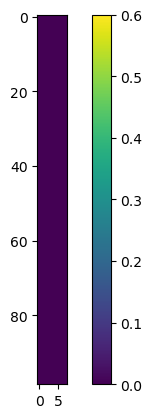

In [73]:
mean_concs = [mean_conc_random,mean_conc_greedy,mean_conc_mimic,mean_conc_landmax]
for mean_conc in mean_concs:
    vmin = 0  # Replace with your desired minimum value
    vmax = 0.6  # Replace with your desired maximum value
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    plt.imshow(np.real(mean_conc[400:499]), interpolation='none',norm=norm)
    plt.colorbar()
    plt.show()

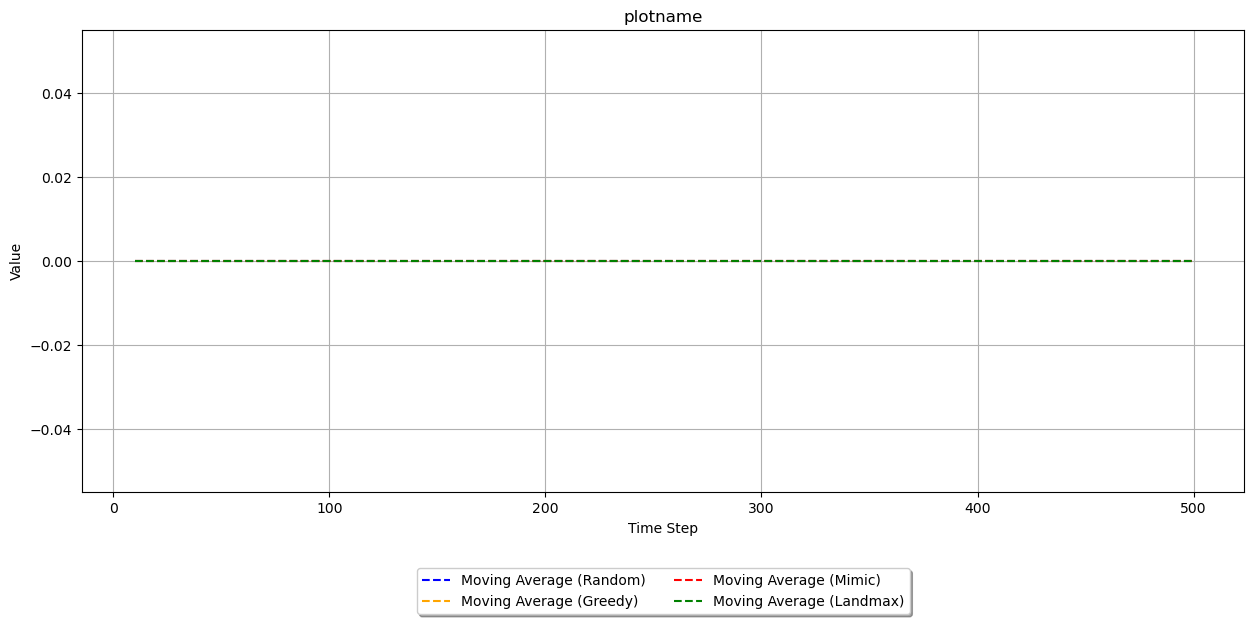

In [74]:
steps=499
size=[8]
conc_std_random=extract_stds(means_stds_mode_of_pops_of_one_sim_index(mean_conc_random))
conc_std_greedy=extract_stds(means_stds_mode_of_pops_of_one_sim_index(mean_conc_greedy))
conc_std_mimic=extract_stds(means_stds_mode_of_pops_of_one_sim_index(mean_conc_mimic))
conc_std_landmax=extract_stds(means_stds_mode_of_pops_of_one_sim_index(mean_conc_landmax))
        
plot_four_stats_as_function_of_time_avg(conc_std_random,conc_std_greedy,conc_std_mimic,conc_std_landmax,filename = 'conc_mean')


In [20]:
def conc_stats_of_Q(means_stds_conc,Q):
    conc_stats = []
    for mean_std_conc in means_stds_conc:
        conc_stats.append(mean_std_conc[Q])
    return conc_stats

In [21]:
conc_stats_Q_random=conc_stats_of_Q(mean_stds_conc_random,2);
conc_stats_Q_greedy=conc_stats_of_Q(mean_stds_conc_greedy,2);
conc_stats_Q_mimic=conc_stats_of_Q(mean_stds_conc_greedy,2);
conc_stats_Q_landmax=conc_stats_of_Q(mean_stds_conc_greedy,2);

In [22]:
def plot_conc_stats_of_Q(conc_stats_Q):
    time_steps = np.arange(0,100)
    mean_stat=[]
    std_stat=[]
    max_stat=[]
    min_stat=[]
    for conc_stat in conc_stats_Q:
        mean_stat.append(conc_stat[0])
        std_stat.append(conc_stat[1])
        max_stat.append(conc_stat[2])
        min_stat.append(conc_stat[3])
    return mean_stat,std_stat,max_stat,min_stat
    
   
    

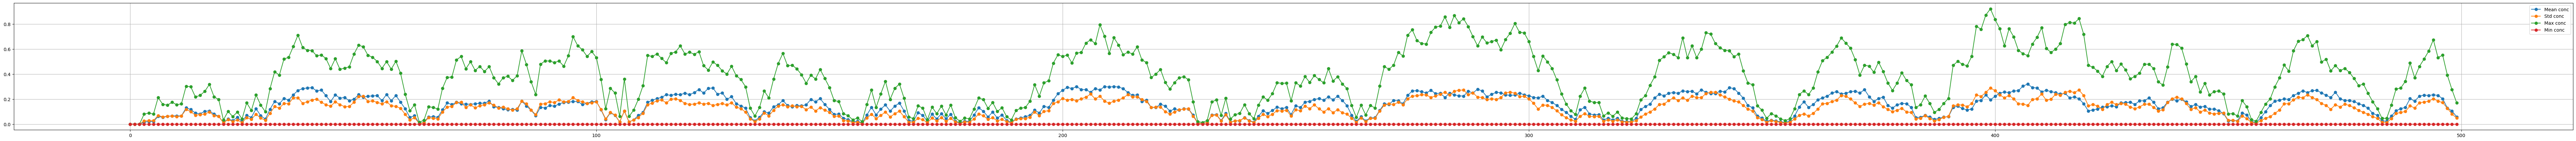

In [50]:
conc_stats_Q=conc_stats_of_Q(mean_stds_conc_random,3);time_steps = np.arange(0,500)
plt.figure(figsize=(100, 5))
plt.plot(time_steps, plot_conc_stats_of_Q(conc_stats_Q)[0], '-o', label='Mean conc')
plt.plot(time_steps, plot_conc_stats_of_Q(conc_stats_Q)[1], '-o', label='Std conc')
plt.plot(time_steps, plot_conc_stats_of_Q(conc_stats_Q)[2], '-o', label='Max conc')
plt.plot(time_steps, plot_conc_stats_of_Q(conc_stats_Q)[3], '-o', label='Min conc')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
rules=["random","greedy","landscape_maximizes","mimic"]
conns = ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]
for conn in conns:
    for rule in rules:
        for unitary_seed in range(1):
            initial_pops = [.01,.01, .01, .45, .01, .01, .01, .01]
            system = DM.n_thermal_qbits(initial_pops)
            connectivity = conn
            unitary_energy_subspace = 1
            ordering_seed = 1
            chunk_size = 2
            order_rule_name = rule
            num_steps = 500
            data = cleo.execute(file_name=rule,
                               connectivity=connectivity,
                               order_rule_name = order_rule_name, 
                               unitary_seed=unitary_seed,
                               unitary_energy_subspace=unitary_energy_subspace,
                               evolution_generation_type="haar2Qunitary",
                               chunk_size=chunk_size,
                               num_steps=num_steps,
                               initial_pops=initial_pops,
                               verbosity = .9)
